## Bank Personal Loan Classification

Universal bank is a small but growing bank. The majority of customers are liability, or deposit only customers, and the bank is interested in converting more of them into asset, or borrowing, customers. The bank has had past success with marketing campaigns to convert the liability customers to personal loan customers. With that success, the bank is interested in being more targeted with its efforts to ensure marketing dollars are spent on those most likely to convert. The bank would like a model to help it predict which new customers are likely to become personal loan customers to aid in this targeting.

## Business Question

Can we predict which new customers are most likely to say yes to a personal loan?

## Import Necessary packages

In [ ]:
import pandas as pd
import numpy as np
from time import time
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, plot_roc_curve
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


## Dataset Analysis

In [ ]:
bank_df = pd.read_csv('https://raw.githubusercontent.com/Nuthi-Sriram/Bank_Loan_Modelling/master/UniversalBank.csv')
bank_df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [ ]:
# Drop columns that are not significant
bank_df = bank_df.drop(['ID', 'ZIP Code'], axis=1)
bank_df.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,25,1,49,4,1.6,1,0,0,1,0,0,0
1,45,19,34,3,1.5,1,0,0,1,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,0,1


In [ ]:
print('Shape:', bank_df.shape)

Shape: (5000, 12)


In [ ]:
bank_df['Personal Loan'].value_counts().rename_axis('Personal Loan').to_frame('No of customers')

,No of customers
Personal Loan,
0,4520
1,480


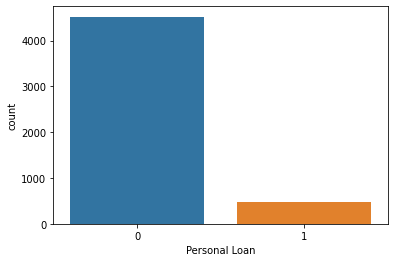

In [ ]:
sns.countplot(bank_df['Personal Loan'])



*   90.4% of the total customers do not take personal loan
*   9.6% of the total customers take personal loan
*   So, the dataset is skewed and we need to deal with this imbalanced dataset



## PCA

In [ ]:
feature = bank_df.copy().drop('Personal Loan', axis=1)
target = bank_df['Personal Loan']

In [ ]:
# Scale data to obtain zero mean and unit variance
scaler = StandardScaler()
feature = scaler.fit_transform(feature)

In [ ]:
# Generate covariance matrix, eigen values, and eigen vectors
features = feature.T
cov_mat = np.cov(features)
eigen_values, eigen_vectors = np.linalg.eig(cov_mat)

In [ ]:
# Sorted array of indices
sorted_index = np.argsort(eigen_values)[::-1]
#sort the eigenvalues in descending order
sorted_eigenvalues = eigen_values[sorted_index]
print('Eigen values in descending order: ', sorted_eigenvalues)
# Sort the eigenvectors 
sorted_eigenvectors = eigen_vectors[:,sorted_index]

Eigen values in descending order:  [2.04891507 1.85678557 1.41461092 1.01636778 0.9975422  0.98367536
 0.92910531 0.89824755 0.51142457 0.34017265 0.00535346]


In [ ]:
total = sum(eigen_values)
explained_var = []
for value in sorted_eigenvalues:
  explained_var.append(np.round((value*100/total), decimals=2))
print('Sum of explained variances is: ', round(sum(explained_var))/100)
print('Explained variances (in %): ', explained_var)
print('Cumulative variances: ', list(np.round(np.cumsum(explained_var), decimals=2)))

Sum of explained variances is:  1.0
Explained variances (in %):  [18.62, 16.88, 12.86, 9.24, 9.07, 8.94, 8.44, 8.16, 4.65, 3.09, 0.05]
Cumulative variances:  [18.62, 35.5, 48.36, 57.6, 66.67, 75.61, 84.05, 92.21, 96.86, 99.95, 100.0]


Clearly, if we consider 6 principal components, then we can obtain a cumulative variance of around 76%

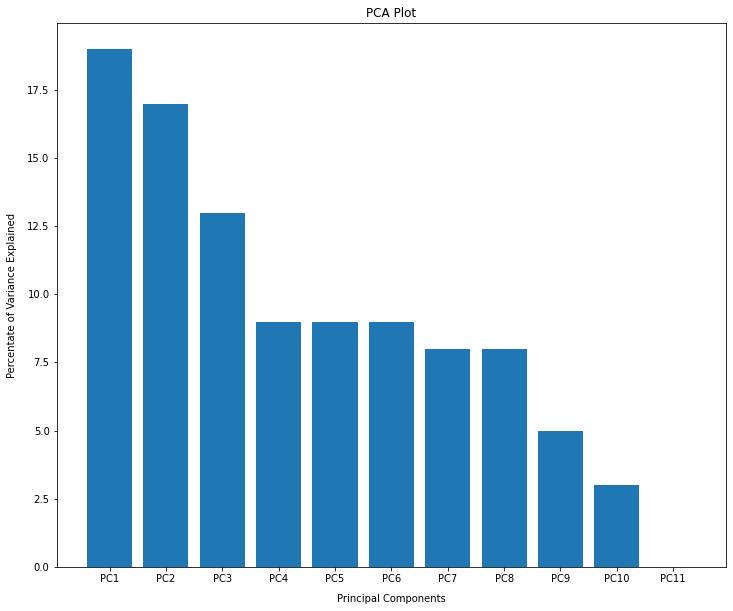

In [ ]:
percent_variance = [round(var) for var in explained_var]
columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10', 'PC11']
fig = plt.figure(figsize=(12, 10))
plt.bar(x= columns, height=percent_variance, tick_label=columns)
plt.ylabel('Percentate of Variance Explained', labelpad=10)
plt.xlabel('Principal Components', labelpad=10)
plt.title('PCA Plot')
plt.show()

In [ ]:
# Consider number of components as 6
eigenvector_subset = sorted_eigenvectors[:,0:6]
# Transorm the original matrix
x_reduced = np.dot(feature, eigenvector_subset)

In [ ]:
# Create a Pandas DataFrame of reduced Dataset with 6 dimensions
x_reduced_df = pd.DataFrame(x_reduced , columns = ['PC1','PC2','PC3','PC4','PC5','PC6'])
# Concatenate it with target variable to create a complete dataset
x_reduced_df['Personal Loan'] = target
x_reduced_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,Personal Loan
0,-2.002079,-1.635217,-1.062531,-2.137542,0.599147,1.938152,0
1,0.147811,-0.558268,-0.801336,-2.091811,0.391042,2.233492,0
2,-0.084117,-1.254918,0.942643,0.045140,-0.480842,1.570128,0
3,-1.362426,-0.267534,1.237181,-0.047862,0.126291,1.192668,0
4,-0.711365,-1.759962,-0.619391,1.470853,0.986634,0.610911,0


#### Final data with dimensionality reduction

In [ ]:
feature = x_reduced_df.drop(['Personal Loan'], axis=1)
feature.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-2.002079,-1.635217,-1.062531,-2.137542,0.599147,1.938152
1,0.147811,-0.558268,-0.801336,-2.091811,0.391042,2.233492
2,-0.084117,-1.254918,0.942643,0.045140,-0.480842,1.570128
3,-1.362426,-0.267534,1.237181,-0.047862,0.126291,1.192668
4,-0.711365,-1.759962,-0.619391,1.470853,0.986634,0.610911


## Plot the pricipal components

#### 1 dimension

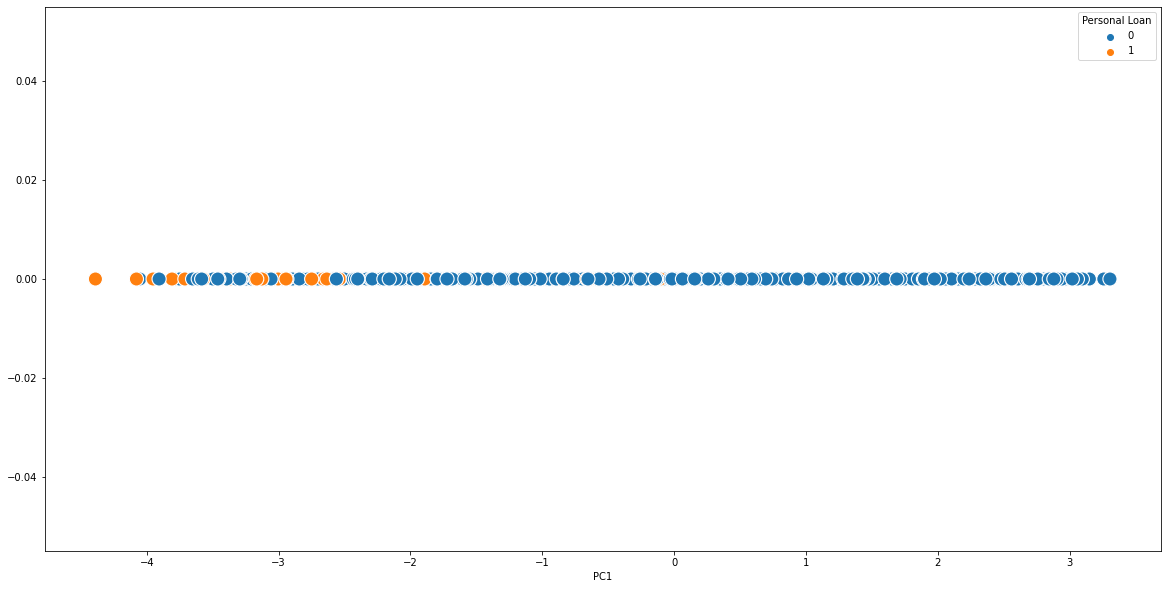

In [ ]:
plt.figure(figsize=(20, 10))
sns.scatterplot(x_reduced_df.PC1, [0] * len(x_reduced_df), hue=x_reduced_df['Personal Loan'], s=200)
plt.show()

#### 2 dimensions

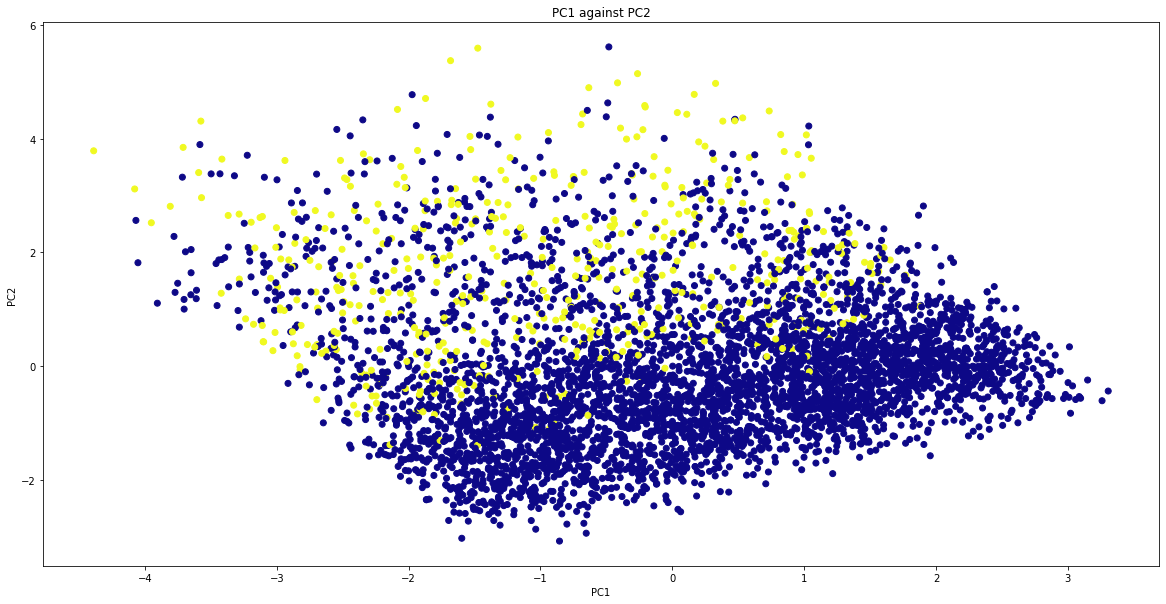

In [ ]:
plt.figure(figsize=(20,10))
plt.scatter(x_reduced_df.PC1, x_reduced_df.PC2, c=x_reduced_df['Personal Loan'],cmap='plasma')
plt.title('PC1 against PC2')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

#### 3 dimensions

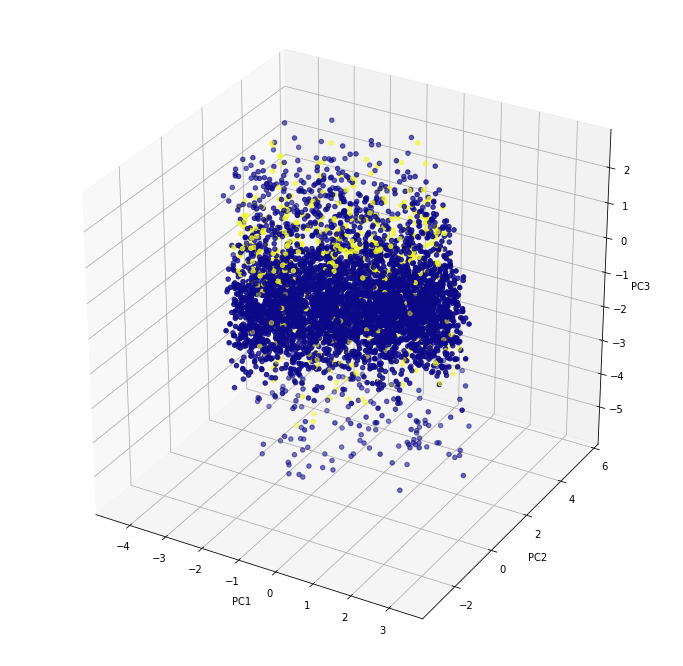

In [ ]:
fig = plt.figure(figsize=(12,12)) 
# Choose projection 3d for creating a 3d graph
axis = fig.add_subplot(111, projection='3d')
axis.scatter(x_reduced_df.PC1,x_reduced_df.PC2,x_reduced_df.PC3, c=x_reduced_df['Personal Loan'],cmap='plasma')
axis.set_xlabel("PC1", fontsize=10)
axis.set_ylabel("PC2", fontsize=10)
axis.set_zlabel("PC3", fontsize=10)
plt.show()

## Split dataset into train & test

In [ ]:
# Split the data into trainx, testx, trainy, testy with test_size = 0.20 using sklearn
x_train, x_test, y_train, y_test = train_test_split(feature, target, stratify=target, random_state=5, test_size=0.20)

In [ ]:
# Print the shape of x_train, x_test, y_train, y_test
print('Shape of x_train :', x_train.shape)
print('Shape of x_test  :', x_test.shape)
print('Shape of y_train :', y_train.shape)
print('Shape of y_test  :', y_test.shape)

Shape of x_train : (4000, 6)
Shape of x_test  : (1000, 6)
Shape of y_train : (4000,)
Shape of y_test  : (1000,)


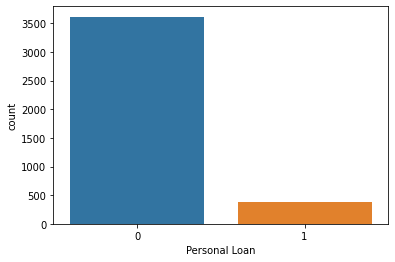

In [ ]:
sns.countplot(y_train)

## Preprocessing the dataset

*   We can balance the dataset either by Up sampling the minority class or Down sampling the majority class. But as the dataset is too small, Down sampling the majority class will not help, so we will Up sample the minority Class.

*   If up sampling is done before splitting the dataset into a train and test set, then it could end up with the same observation in both datasets.

*   As a result, a machine learning model will be able to perfectly predict the value for those observations when predicting on the test set, hence inflating the accuracy and recall.

*   So, up sampling should be done only on the train set, after splitting the dataset into train and test.

In [ ]:
# Balance the dataset by oversampling technique
smote = SMOTE(random_state = 10)
x_train, y_train = smote.fit_sample(x_train, y_train)

In [ ]:
# Print the shape of x_train, x_test, y_train, y_test after oversampling
print('Shape of x_train :', x_train.shape)
print('Shape of x_test  :', x_test.shape)
print('Shape of y_train :', y_train.shape)
print('Shape of y_test  :', y_test.shape)

Shape of x_train : (7232, 6)
Shape of x_test  : (1000, 6)
Shape of y_train : (7232,)
Shape of y_test  : (1000,)


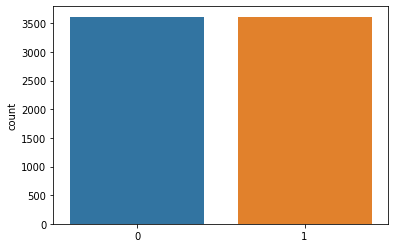

In [ ]:
sns.countplot(y_train)

## KNN Classifier

In [ ]:
# Create KNN object
knn_classifier = KNeighborsClassifier(algorithm='brute')

In [ ]:
t = time()
# Train the model
knn_classifier.fit(x_train, y_train)
# Time is rounded to 3 decimal in seconds
print("Training time:", round(time()-t, 3), "s")

Training time: 0.002 s


In [ ]:
# Predict train data set
pred_train = knn_classifier.predict(x_train)
# Predict test data set
pred_test = knn_classifier.predict(x_test)

In [ ]:
# list the default parameters of the model
knn_classifier.get_params()

{'algorithm': 'brute',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

#### Performance of our model

In [ ]:
print("Accuracy on train is:", accuracy_score(y_train, pred_train))
print("Accuracy on test is:", accuracy_score(y_test, pred_test))

Accuracy on train is: 0.9581028761061947
Accuracy on test is: 0.899


In [ ]:
# Checking performance of our model with classification report
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94       904
           1       0.48      0.83      0.61        96

    accuracy                           0.90      1000
   macro avg       0.73      0.87      0.78      1000
weighted avg       0.93      0.90      0.91      1000



In [ ]:
# Checking performance of our model with ROC Score
print('ROC Score:', roc_auc_score(y_test, pred_test))

ROC Score: 0.8696533923303835


## Hyper Parameter Tuning

In [ ]:
# List hyper parameters that we wish to tune
params = {'n_neighbors': list(range(1,25)), 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'cityblock', 'minkowski']}
# Use grid search
grid = GridSearchCV(knn_classifier, verbose=1, param_grid=params, scoring='roc_auc', cv=10)

In [ ]:
# Train the model
grid.fit(x_train, y_train)
print()

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Parallel(n_jobs=1)]: Done 1440 out of 1440 | elapsed:  2.7min finished


In [ ]:
print('Best Score:', grid.best_score_)
print('Best Parameters:', grid.best_params_)

Best Score: 0.9866755174574593
Best Parameters: {'metric': 'cityblock', 'n_neighbors': 21, 'weights': 'distance'}


In [ ]:
best_knn = grid.best_estimator_
# print best hyper parameters
print(best_knn)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='cityblock',
                     metric_params=None, n_jobs=None, n_neighbors=21, p=2,
                     weights='distance')


In [ ]:
t = time()
# Train the model
best_knn.fit(x_train, y_train)
# Time is rounded to 3 decimal in seconds
print("Training time:", round(time()-t, 3), "s")

Training time: 0.003 s


In [ ]:
# Predict train data set
pred_train = best_knn.predict(x_train)
# Predict test data set
pred_test = best_knn.predict(x_test)

In [ ]:
print("Accuracy on train is:", accuracy_score(y_train, pred_train))
print("Accuracy on test is:", accuracy_score(y_test, pred_test))

Accuracy on train is: 1.0
Accuracy on test is: 0.887


#### Confusion matrix for Train data

In [ ]:
# Print confusion matrix for train data
print(confusion_matrix(y_train, pred_train))

[[3616    0]
 [   0 3616]]


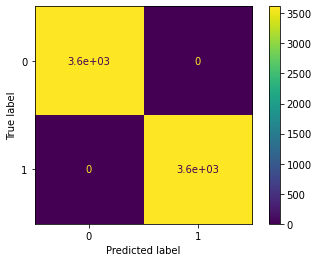

In [ ]:
# Plot confusion matrix for train data
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_train, pred_train), display_labels=grid.classes_).plot()

#### Confusion matrix for Test data

In [ ]:
# Print confusion matrix for test data
print(confusion_matrix(y_test, pred_test))

[[802 102]
 [ 11  85]]


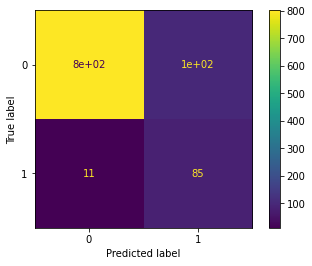

In [ ]:
# Plot confusion matrix for test data
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, pred_test), display_labels=grid.classes_).plot()

#### Performance of our model

In [ ]:
# Checking performance of our model with classification report
print(classification_report(y_test, pred_test))

              precision    recall  f1-score   support

           0       0.99      0.89      0.93       904
           1       0.45      0.89      0.60        96

    accuracy                           0.89      1000
   macro avg       0.72      0.89      0.77      1000
weighted avg       0.94      0.89      0.90      1000



In [ ]:
# Checking performance of our model with ROC Score
print('ROC Score:', roc_auc_score(y_test, pred_test))

ROC Score: 0.8862924041297935


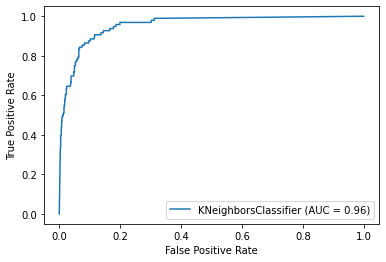

In [ ]:
# Plot ROC Curve
plot_roc_curve(best_knn, x_test, y_test)

## Overall Analysis



*   This is an imbalanced dataset. So, I have upsampled the train data and preprocessed the data using StandardScaler to obtain 0 mean and unit variance. Doing this improved the accuracy and ROC score of the model to a great extent.

*   Also, I have used stratify parameter to preserve the proportion of target as in original dataset, in the train and test datasets as well.

*   As per the results, accuracy is 0.89. But our dataset is skewed. So, instead of considering accuracy as our metric, we need to consider ROC_AUC score for highly skewed datasets.

*   Default parameters of the model gave an ROC score of 0.87 & accuracy of 0.9, whereas after hyperparameter tuning, accuracy reduced to 0.89 and ROC score raised to 0.89. So, I have considered the tuned parameters for our model.

